In [1]:
%load_ext autoreload
%autoreload 2
from inxss.utils_spectrum import calc_Sqw_from_Syy_Szz
from inxss.experiment import SimulatedExperiment

import torch
import numpy as np
from scipy.interpolate import RegularGridInterpolator

from inxss import SpectrumDataset, SpecNeuralRepr, Particle, PsiMask, OnlineVariance, linspace_2D_equidistant
from inxss.utils_visualization import arc_arrow, rad_arrow

import matplotlib.pyplot as plt

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

torch.set_default_dtype(torch.float32)

In [2]:
from inxss.experiment import NeutronExperiment, SimulatedExperiment

In [3]:
model_path = '/pscratch/sd/z/zhantao/inxs_steering_production/models/version_14896845/checkpoints/epoch=7160-step=343728.ckpt'
data = torch.load('/pscratch/sd/z/zhantao/inxs_steering_production/experiment_data/summarized_neutron_data_w_bkg_260meV_ML.pt')
print(data.keys())

dict_keys(['grid', 'S', 'background', 'background_dict'])


### setup experiment simulator

In [4]:
from inxss.experiment import Background

In [5]:
background = Background(
    tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), 
    data['grid']['w_grid'], 
    data['background']
)

### Testing integrated steer module

In [6]:
from inxss.steer_neutron import NeutronExperimentSteerer
# from inxss.steer_neutron_oldver import NeutronExperimentSteerer

In [7]:
particle_filter_config = {
    "num_particles": 1000,
    "dim_particles": 2,
    "prior_configs": {'types': ['uniform', 'uniform'], 'args': [{'low': 20, 'high': 40}, {'low': -5, 'high': 5}]}
}


grid_info = {
    'h_grid': [-2.0, 2.0, 121],
    'k_grid': [-2.0, 2.0, 121],
    'l_grid': [-10.0, 4.5, 30],
    'w_grid': [20.0, 200.0, 91]
}
# grid_info = {
#     _: [eval(f'neutron_exp.{_}').min().item(), eval(f'neutron_exp.{_}').max().item(), eval(f'neutron_exp.{_}').shape[0]] 
#     for _ in ['h_grid', 'k_grid', 'l_grid', 'w_grid']}

mask_config = {
    "raw_mask_path": '/pscratch/sd/z/zhantao/inxs_steering/La2NiO4_bool',
    "memmap_mask_path": '/pscratch/sd/z/zhantao/inxs_steering/mask_data',
    "grid_info": grid_info,
    "preload": False,
    "build_from_scratch_if_no_memmap": True,
    "global_mask": data['S']>0
}

experiment_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "S_grid": data['S'],
    "S_scale_factor": 1.
}

background_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "bkg_grid": data['background']
}

model = SpecNeuralRepr.load_from_checkpoint(model_path).to(device)

steer = NeutronExperimentSteerer(
    model, particle_filter_config=particle_filter_config,
    mask_config=mask_config, experiment_config=experiment_config, background_config=background_config,
    likelihood_sample_ratio=0.25, tqdm_pbar=False, device='cuda')

obtained memmap mask name as: mask_h_-2.0_2.0_121_k_-2.0_2.0_121_l_-10.0_4.5_30_w_20.0_200.0_91.npy


In [8]:
mean_list = []
std_list = []
steer.reset()

In [21]:
with torch.no_grad():
    progress_bar = tqdm(range(50))
    for i in progress_bar:
        steer.step_steer()
        current_mean = steer.particle_filter.mean().detach().cpu()
        current_std = steer.particle_filter.std().detach().cpu()
        progress_bar.set_description(
            f'means: [{current_mean[0]:.3f}, {current_mean[1]:.3f}] '
            f' stds: [{current_std[0]:.3f}, {current_std[1]:.3f}]'
        )
        mean_list.append(current_mean)
        std_list.append(current_std)


means: [29.060, 1.785]  stds: [0.284, 0.199]: 100%|██████████| 50/50 [09:14<00:00, 11.09s/it]


In [22]:
steer.particle_filter.mean()

tensor([29.0602,  1.7852], dtype=torch.float64, grad_fn=<SumBackward1>)

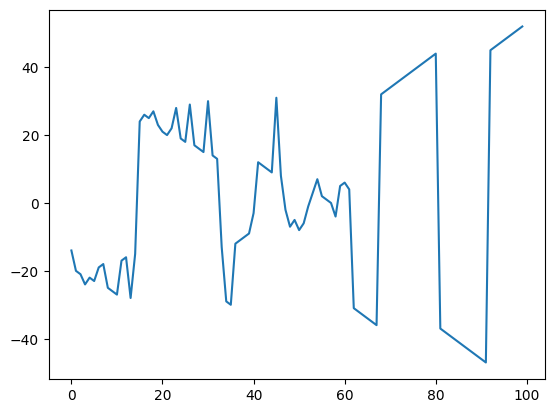

In [23]:
measured_angles = np.vstack(steer.measured_angles_history).squeeze()
measured_angles[measured_angles > 180] -= 360
measured_angles
plt.plot(measured_angles)

In [24]:
from inxss.utils_visualization import visualize_utility

<PolarAxesSubplot:>

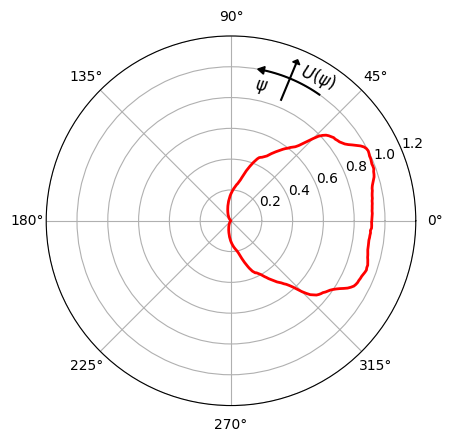

In [25]:
visualize_utility(steer.psi_mask.psi_grid, steer.utility_history[-1])

In [26]:
means = torch.vstack(mean_list).detach().numpy()[:]
std_dev = torch.vstack(std_list).detach().numpy()[:]

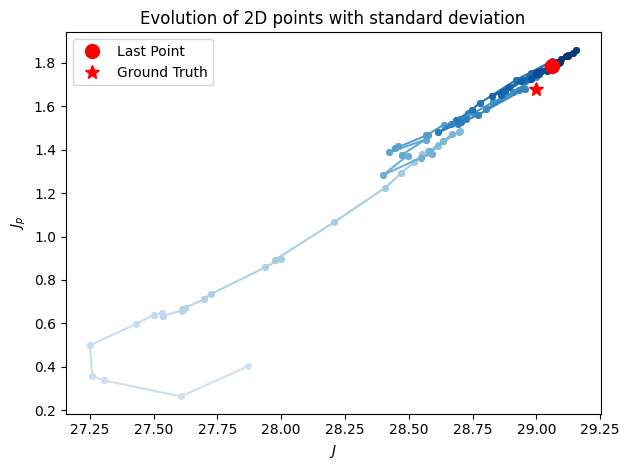

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create some dummy data
scale_factor = 0.25
N = means.shape[0]
# means = np.cumsum(np.random.randn(N, 2), axis=0)
# stds = np.abs(np.random.randn(N, 2))

# Visualization
fig, ax = plt.subplots()

cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0.2, 1, N)]

# Plot the evolution of the points with colormap
for i in range(N-1):
    ax.plot(means[i:i+2, 0], means[i:i+2, 1], '-o', color=colors[i], markersize=4)


# # Plot ovals for standard deviation
# for i in range(N):
#     ellipse = patches.Ellipse((means[i, 0], means[i, 1]),
#                               width=std_dev[i, 0]*scale_factor,  
#                               height=std_dev[i, 1]*scale_factor,
#                               edgecolor=None, facecolor=colors[i], alpha=0.2)  
#     ax.add_patch(ellipse)

ax.plot(means[-1,0], means[-1,1], 'o', label='Last Point', markersize=10, color='red')
ax.plot(29.0, 1.68, '*', label='Ground Truth', markersize=10, color='red')

ax.set_title('Evolution of 2D points with standard deviation')
ax.set_xlabel('$J$')
ax.set_ylabel('$J_{p}$')
# ax.set_xlim(20, 40)
# ax.set_ylim(-5, 5)
ax.legend()

plt.tight_layout()
plt.show()


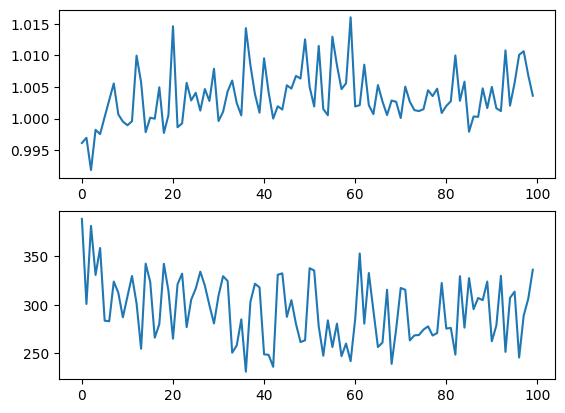

In [28]:
fig, axes = plt.subplots(2,1)
axes[0].plot(torch.stack(steer.sig_bkg_factors_history).numpy()[:,0])
axes[1].plot(torch.stack(steer.sig_bkg_factors_history).numpy()[:,1])

In [29]:
from inxss import linspace_2D_equidistant, plot_points, get_Sqw_func

kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
wpts = steer.experiment.w_grid
qw_coords = []
for _l in steer.experiment.l_grid:
    _qw_coords = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
       ], dim=2)
    qw_coords.append(_qw_coords)

In [30]:
S_exp = 0.
for _qw_coords in qw_coords:
    S_exp += steer.experiment.get_measurements_on_coords(_qw_coords)

In [31]:
params = steer.particle_filter.mean()
# params = torch.tensor([29, 1.7])
x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)
x[...,:3] = torch.cat([
    kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
    wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
   ], dim=2)
x[...,3:] = params

S_pred = model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy()

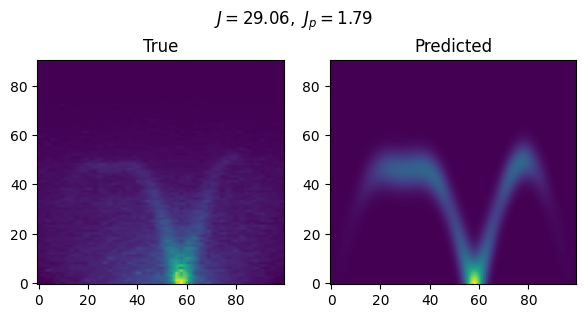

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(S_exp, origin='lower')
ax[0].set_title('True')
ax[1].imshow(S_pred, origin='lower')
ax[1].set_title('Predicted')

fig.suptitle(rf'$J={params[0]:.2f}, \ J_{{p}}={params[1]:.2f}$')
fig.tight_layout()
# fig.savefig(f"test_idx_{idx_plot}.svg", bbox_inches='tight')